### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
#import data

import matplotlib.pyplot as plt
# HUNGRY_DECONV = np.load('../../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)
HUNGRY_DECONV = np.load('../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)

print(HUNGRY_DECONV.shape)

FOOD_RESTRICTED_HUNGRY = [1,2,3,6,7,9,11,12]
CONTROL_HUNGRY = [0,4,5,8,10,13]


# AngStim_data = '../../Data/metadata_deconv/stimAngle_hungry.mat'
AngStim_data = '../Data/metadata_deconv/stimAngle_hungry.mat'

ANG_STIM_DATA = loadmat(AngStim_data, simplify_cells= True)
HUNGRY_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
print(HUNGRY_ANGLE[0].shape)

# SfStim_data = '../../Data/metadata_deconv/stimSpatFreq_hungry.mat'
SfStim_data = '../Data/metadata_deconv/stimSpatFreq_hungry.mat'

SF_STIM_DATA = loadmat(SfStim_data, simplify_cells= True)
HUNGRY_SF = SF_STIM_DATA['stimSpatFreq_arossAnimals']
print(HUNGRY_SF[0].shape)

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



(14, 60)
(12, 55)
(55,)
450560


In [3]:
TEST_DATA = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)[:,:,:,:,40:80]
good_trials = ~jnp.isnan(TEST_DATA).all(axis=(1, 2, 3,4))   # shape (K,)
TEST_RESPONSE = TEST_DATA[good_trials]   
print(TEST_RESPONSE.shape)
x = TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0],TEST_RESPONSE.shape[1],TEST_RESPONSE.shape[2],-1)
print(x.shape)
np.save('test_data_seb_tom.npy', x)

(128, 12, 5, 11, 40)
(128, 12, 5, 440)


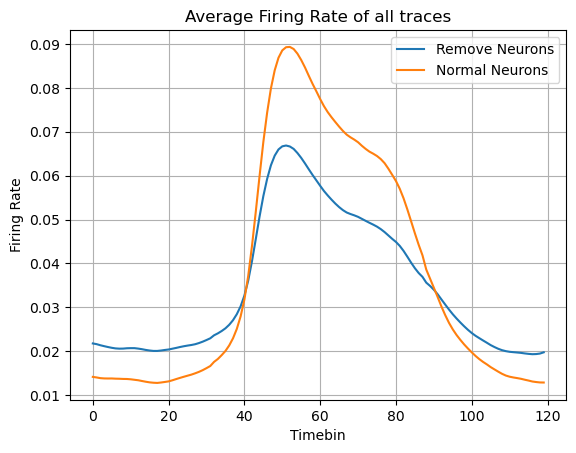

In [4]:
remove_mean = np.zeros((14,120))
normal_mean = np.zeros((14,120))
for i in range(14):
    remove_mean[i,:] = np.nanmean(resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
    normal_mean[i,:] = np.nanmean(remove_neurons(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
plt.plot(np.mean(remove_mean,axis=0), label = 'Remove Neurons')
plt.plot(np.mean(normal_mean,axis=0), label = 'Normal Neurons')
plt.xlabel('Timebin')
plt.ylabel('Firing Rate')
plt.title('Average Firing Rate of all traces')
plt.legend()
plt.grid()

In [ ]:
TEST_DATA = resort_preprocessing(HUNGRY_DECONV, HUNGRY_ANGLE, HUNGRY_SF, 1)[:, :, :, :, 40:80]
TEST_RESPONSE = jnp.nanmean(TEST_DATA, axis=-1)  # (N, C1, C2, K)

nan_mask = jnp.isnan(TEST_RESPONSE)  # shape (N, C1, C2, K)

# Identify bad K indices: any NaNs anywhere along N, C1, C2
bad_k = nan_mask.any(axis=(0, 1, 2))  # shape (K,)
good_k = ~bad_k

# Filter to only good K units
TEST_RESPONSE = TEST_RESPONSE[:, :, :, good_k]
print(jnp.isnan(TEST_RESPONSE).any())  # Should be False
print(TEST_RESPONSE.shape)
N = TEST_RESPONSE.shape[0]
K = TEST_RESPONSE.shape[3]
C1 = TEST_RESPONSE.shape[1]
C2 = TEST_RESPONSE.shape[2]



# 2D condition space: 12 angles (first axis, C1), 5 spatial frequencies (second axis, C2)
X_CONDITIONS = jnp.stack(jnp.meshgrid(jnp.arange(C1), jnp.arange(C2), indexing='ij'), axis=-1).reshape(-1, 2)
# print(X_CONDITIONS.shape)

# Reshape test response to match the condition space
TEST_RESPONSE_flat = TEST_RESPONSE.reshape(N, C1*C2, K)
TEST_RESPONSE_transposed = jnp.transpose(TEST_RESPONSE_flat, (2, 1, 0)) # Now we need to transpose to get K x (C1*C2) x N
Y_RESPONSE = TEST_RESPONSE_transposed
# print(Y_RESPONSE.shape)

SEED = 1
PERIOD = C1
# print(X_CONDITIONS)

False
False
(165, 12, 5, 9)


: 

In [6]:

hyperparams = {
    'lambda_gp_angle': 1.8103336,
    'gamma_gp_angle': 4.5379544e-05,
    'beta_gp_angle': 0.12863505,

    'lambda_gp_sf': 0.26290625,
    'gamma_gp_sf': 0.00011522,
    'beta_gp_sf': 0.1991709,

    'lambda_wp_angle': 0.22797374,
    'gamma_wp_angle': 0.00010354,
    'beta_wp_angle': 1.6773869,

    'lambda_wp_sf': 0.36553314,
    'gamma_wp_sf': 2.8193786e-05,
    'beta_wp_sf': 0.27211133,

    'p': 1
}




In [7]:
# Initialise Kernel and Model
periodic_kernel_gp_angle = lambda x, y: hyperparams['gamma_gp_angle']*(x==y) + hyperparams['beta_gp_angle']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['lambda_gp_angle']))
square_kernel_gp_sf = lambda x, y: hyperparams['gamma_gp_sf']*(x==y) + hyperparams['beta_gp_sf']*jnp.exp(-(x-y)**2/(hyperparams['lambda_gp_sf']))
kernel_gp = lambda x, y: periodic_kernel_gp_angle(x[0], y[0]) * square_kernel_gp_sf(x[1], y[1])
# kernel_gp = lambda x, y: periodic_kernel_gp_angle(x[1], y[1]) * square_kernel_gp_sf(x[0], y[0])

periodic_kernel_wp_angle = lambda x, y: hyperparams['gamma_wp_angle']*(x==y) + hyperparams['beta_wp_angle']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['lambda_wp_angle']))
square_kernel_wp_sf = lambda x, y: hyperparams['gamma_wp_sf']*(x==y) + hyperparams['beta_wp_sf']*jnp.exp(-(x-y)**2/(hyperparams['lambda_wp_sf']))
kernel_wp = lambda x, y: periodic_kernel_wp_angle(x[0], y[0]) * square_kernel_wp_sf(x[1], y[1])
# kernel_wp = lambda x, y: periodic_kernel_wp_angle(x[1], y[1]) * square_kernel_wp_sf(x[0], y[0])

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=kernel_gp,N=N)
# wp = models.WishartProcess(kernel = kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
wp = models.WishartLRDProcess(kernel=kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)


Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [8]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,Y_RESPONSE,n_iter = 50,key=key)
joint.update_params(varfam.posterior)

/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
/home/scastedo/wishart-process/inference.py:29: UserWarning: Site y: Out-of-support values provided to log prob method. The value argument should be within the support.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)


RuntimeError: Cannot find valid initial parameters. Please check your model again.

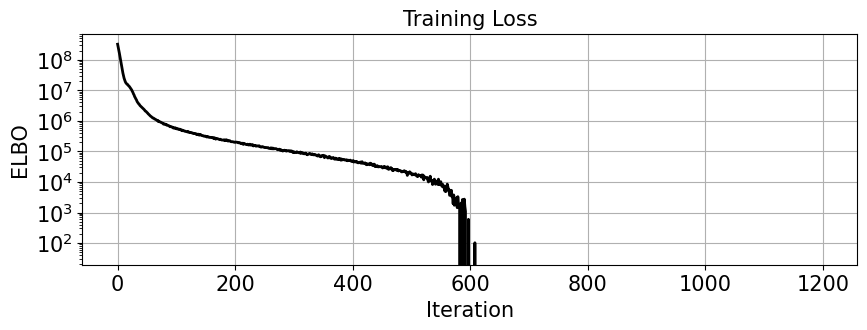

In [12]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


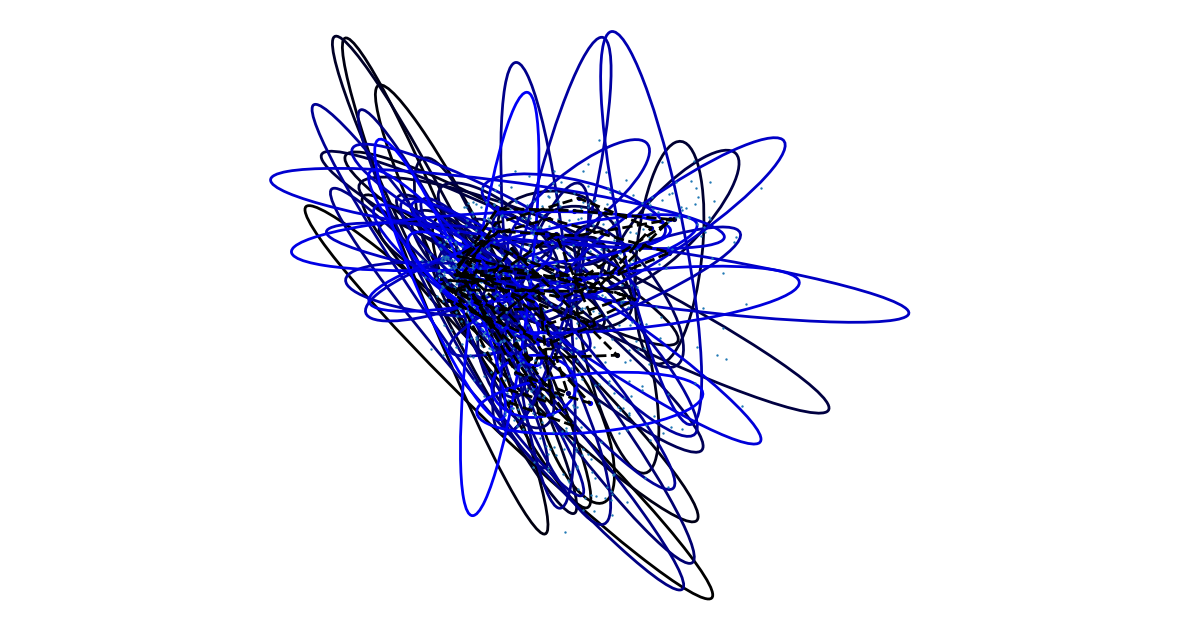

In [15]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=Y_RESPONSE.reshape(Y_RESPONSE.shape[0]*Y_RESPONSE.shape[1],-1)
)


# Compare to Empirical

In [17]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)



(12, 5, 11)


ValueError: Incompatible shapes for broadcasting: (11, 11) and requested shape (128, 128)


# Test Unseen conditions 

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


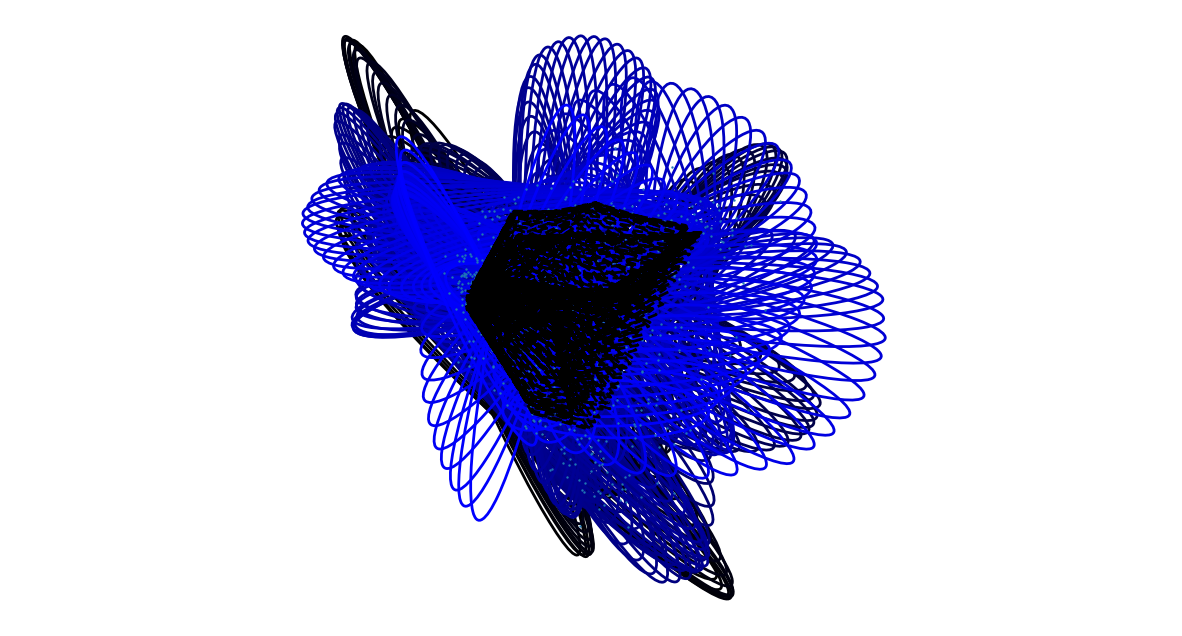

In [18]:
# Given
# -----
# X_test : ndarray, (num_test_conditions x num_variables), test data from first network.

# Interpolate covariances in unseen test conditions 
# test at 200 points instead of C




with numpyro.handlers.seed(rng_seed=1):
    # X_TEST_CONDITIONS = jnp.linspace(0, C-1, 48)
    X_TEST_CONDITIONS = jnp.stack(jnp.meshgrid(jnp.linspace(0, C1-1, 100), jnp.linspace(0, C2-1, 5), indexing='ij'), axis=-1).reshape(-1, 2)
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(X_TEST_CONDITIONS)    
    visualizations.visualize_pc(
        mu_test_hat[:,None],sigma_test_hat,pc=Y_RESPONSE.reshape(Y_RESPONSE.shape[0]*Y_RESPONSE.shape[1],-1)
    )


(100, 5, 128) (100, 5, 128, 128)
(100, 128) (100, 128, 128)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


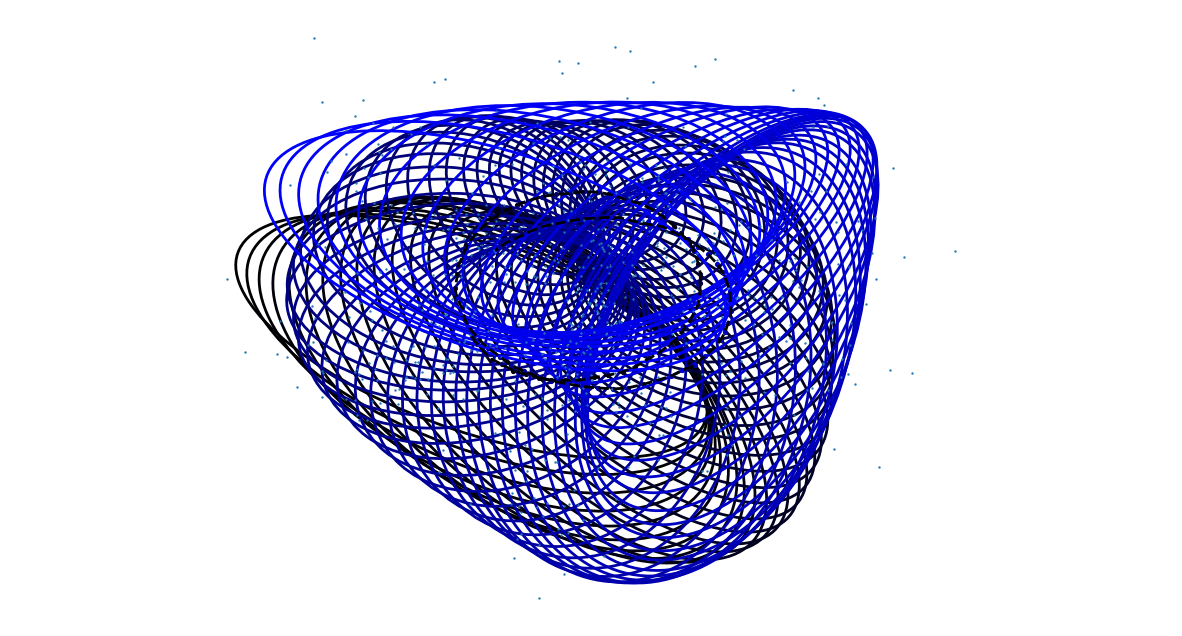

In [33]:
# Reshape mu_test_hat and sigma_test_hat to (C1, C2, N) and (C1, C2, N, N)
C1, C2 = 100, 5
N = mu_test_hat.shape[1]
mu_test_hat_reshaped = mu_test_hat.reshape(C1, C2, N)
sigma_test_hat_reshaped = sigma_test_hat.reshape(C1, C2, N, N)
print(mu_test_hat_reshaped.shape, sigma_test_hat_reshaped.shape)

# Average over spatial frequencies (axis=1)
mu_test_hat_angle = np.nanmean(mu_test_hat_reshaped, axis=1)
sigma_test_hat_angle = np.nanmean(sigma_test_hat_reshaped, axis=1)
print(mu_test_hat_angle.shape, sigma_test_hat_angle.shape)
visualizations.visualize_pc(
    mu_test_hat_angle[:,None],sigma_test_hat_angle,pc=Y_RESPONSE.reshape(Y_RESPONSE.shape[0]*Y_RESPONSE.shape[1],-1)
)

overlaps_fr_normal shape: (8, 12, 5, 50)
eigs_fr_normal shape: (8, 12, 5, 50)
total_snr fr: 32.30317736506278
total_snr fr super: 1.0508869836205688
total_snr ctr: 29.137143574695717
total_snr ctr super: 1.1056612616346342


(0.0, 0.01)

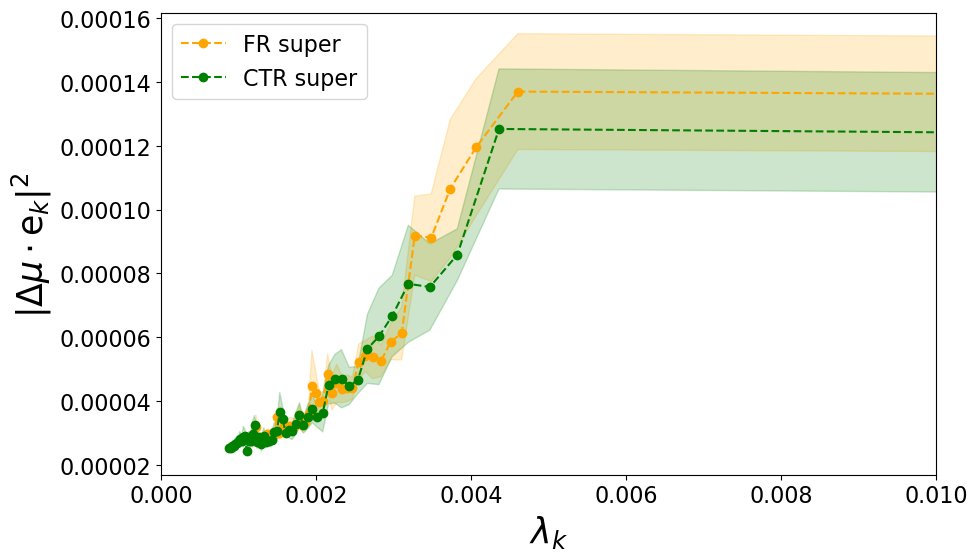

In [2]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('../Data/overlaps_sated_food_restricted_super_2d_0.npz')
overlaps_fr_normal = data['overlaps_fr_normal']
eigs_fr_normal = data['eigs_fr_normal']
overlaps_fr_super = data['overlaps_fr_super']
eigs_fr_super = data['eigs_fr_super']

print('overlaps_fr_normal shape:', overlaps_fr_normal.shape)
print('eigs_fr_normal shape:', eigs_fr_normal.shape)

def extract_plot_vectors(overlaps, eigs):
    total_k = eigs.shape[-1]
    n_anim = overlaps.shape[0]
    evals_plot = np.zeros((n_anim, total_k))
    dots_plot  = np.zeros((n_anim, total_k))

    for i in range(n_anim):
        evals_plot[i] = np.nanmean(eigs[i,:,:,:], axis=(0,1))
        dots_plot[i] = np.nanmean(overlaps[i,:,:,:], axis=(0,1)) # → (total_k,)

    return evals_plot, dots_plot, 

# Extract for each group
fr_evals_plot, fr_dots_plot = extract_plot_vectors(overlaps_fr_normal, eigs_fr_normal)

# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.figure(figsize=(10, 6))
# plt.plot(x_fr, y_fr, 'o--', color='red',   label='FR')
# plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='red',   alpha=0.2)

print('total_snr fr:', np.sum((y_fr/x_fr)))

fr_evals_plot, fr_dots_plot = extract_plot_vectors(overlaps_fr_super, eigs_fr_super)
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.plot(x_fr, y_fr, 'o--', color='orange',   label='FR super')
plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='orange',   alpha=0.2)
print('total_snr fr super:', np.sum((y_fr/x_fr)))


data = np.load('../Data/overlaps_sated_control_super_2d_0.npz')
overlaps_ctr_normal = data['overlaps_ctr_normal']
eigs_ctr_normal = data['eigs_ctr_normal']
overlaps_ctr_super = data['overlaps_ctr_super']
eigs_ctr_super = data['eigs_ctr_super']


# Extract for each group
ctr_evals_plot, ctr_dots_plot = extract_plot_vectors(overlaps_ctr_normal, eigs_ctr_normal)
# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_ctr = np.nanmean(ctr_evals_plot, axis=0)
y_ctr = np.nanmean(ctr_dots_plot, axis=0)
sem_ctr = np.nanstd(ctr_dots_plot, axis=0, ddof=1) / np.sqrt(ctr_dots_plot.shape[0])
# plt.plot(x_ctr, y_ctr, 'o--', color='blue', label='CTR ')
# plt.fill_between(x_ctr, y_ctr - sem_ctr, y_ctr + sem_ctr, color='blue', alpha=0.2) 
print('total_snr ctr:', np.sum((y_ctr/x_ctr)))
     
# Extract for each group
ctr_evals_plot, ctr_dots_plot = extract_plot_vectors(overlaps_ctr_super, eigs_ctr_super)
x_ctr = np.nanmean(ctr_evals_plot, axis=0)
y_ctr = np.nanmean(ctr_dots_plot, axis=0)
sem_ctr = np.nanstd(ctr_dots_plot, axis=0, ddof=1) / np.sqrt(ctr_dots_plot.shape[0])
plt.plot(x_ctr, y_ctr, 'o--', color='green', label='CTR super')
plt.fill_between(x_ctr, y_ctr - sem_ctr, y_ctr + sem_ctr, color='green', alpha=0.2) 
print('total_snr ctr super:', np.sum((y_ctr/x_ctr)))




plt.xlabel(r'$\lambda_k$',fontsize = 25)
plt.ylabel(r'$|\Delta \mu \cdot \text{e}_k|^2$',fontsize = 25)
# plt.ylabel(r'$\cos^2(\theta_k)$', fontsize = 25)
plt.legend(fontsize =16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,0.01)
# plt.savefig('eigenvalue_dot_product.svg',bbox_inches='tight')